In [63]:
import os
import cv2
import glob
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
from PIL import Image
from ultralytics import YOLO

### Train

In [ ]:
# Load a pretrained YOLO model (for training)
model = YOLO("yolov8n.pt")

# Train the model using the .yaml dataset for 300 epochs (default is 100) with "AdamW" (default) optimizer
results = model.train(
    name="corn_kernel_baseline",
    data="corn_yolo.yaml",
    batch=16,
    epochs=300,
    device=0,
    patience=50,
    max_det=900,  # max detections per image
    augment=True,  # augment training data
    erasing=0.1,  # random erasing
    degrees=180,  # image rotation (+/- deg)
    flipud=0.5,  # horizontal flip
    fliplr=0.5,  # vertical flip
    hsv_h=0.1,  # image HSV-Hue
    hsv_s=0.1,  # image HSV-Saturation
    hsv_v=0.2,  # image HSV-Value (brightness)
) 

### Validate

In [ ]:
def validate_model(model_path, val_name, data_path="corn_yolo.yaml", iou=0.5, split="val"):
    model = YOLO(model_path)
    metrics = model.val(data=data_path, name=val_name, max_det=900, iou=iou, split=split, plots=True)
    print(f"Mean average precision (mAP)\n \
        mAP@.50-.95: {metrics.box.map}\n \
        mAP@.50: {metrics.box.map50}\n \
        mAP@.75: {metrics.box.map75}")
    return metrics

In [ ]:
# Validate models with val dataset
model_baseline = "runs/detect/corn_kernel_baseline/weights/best.pt"
metrics_baseline_val = validate_model(model_baseline,"corn_kernel_baseline_val")
model_adam = "runs/detect/corn_kernel_adam/weights/best.pt"
metrics_adam = validate_model(model_adam, "corn_kernel_adam_val")
model_sgd = "runs/detect/corn_kernel_sgd/weights/best.pt"
metrics_sgd = validate_model(model_sgd, "corn_kernel_sgd_val")

In [ ]:
# Validate models with test dataset
# Baseline
metrics_baseline_test = validate_model(model_baseline,"corn_kernel_baseline_test", split="test")
# Adam
metrics_adam_test = validate_model(model_adam,"corn_kernel_adam_test", split="test")
# SGD
metrics_sgd_test = validate_model(model_sgd,"corn_kernel_sgd_test", split="test")

### Predict

In [ ]:
# Predict and save images with centroids
for model_path in [model_baseline, model_adam, model_sgd]:
    run_name = f"{model_path.split("/")[-3]}_pred"
    model = YOLO(model_path)
    results = model.predict(
        source="datasets/corn_kernel_yolo/images/test/*.jpg",
        name=run_name,
        max_det=900,
        iou=0.5,
        show_labels=False,
        line_width=1,
        save=True,
        save_txt=True,
        classes=[0,],
    )
    # Create output directory if it does not exist
    image_output_dir = f"runs/detect/{run_name}/centroids/"
    os.makedirs(image_output_dir, exist_ok=True)
    for r in results:
        im_array = r.orig_img # plot a BGR numpy array of predictions
        # Overlay centroids on image
        for box in r.boxes.xyxy:  # Assuming 'box' is in [x1, y1, x2, y2] format
            centroid_x = (box[0] + box[2]) / 2
            centroid_y = (box[1] + box[3]) / 2
            im_array = cv2.circle(im_array, (int(centroid_x), int(centroid_y)), 4, (0, 0, 255), -1)
        im = Image.fromarray(im_array[..., ::-1]) # RGB PIL image
        filename = f"{Path(r.path).name}"
        im.save(f"{image_output_dir}{filename}") # save image

In [2]:
# Given a directory, count the number of annotations/predictions in each label output
def count_instances(dir):
    """
    Count the number of annotated/predicted instances in each label file in the given directory.

    Args:
    - dir (str): The directory containing the label .txt files.

    Returns:
    - counts (dict): A dictionary containing the number of annotated/predicted instances for each image.
    """
    counts = {}
    for file in glob.glob(dir + "*.txt"):
        with open(file, "r") as in_file:
            lines = in_file.readlines()
        counts[Path(file).name] = len(lines)
    return counts

In [80]:
test_dict = count_instances("../datasets/corn_kernel_yolo/labels/test/")
train_dict = count_instances("../datasets/corn_kernel_yolo/labels/train/")
val_dict = count_instances("../datasets/corn_kernel_yolo/labels/val/")
predicted_dict_adam = count_instances("runs/detect/corn_kernel_adam_pred/labels/")
predicted_dict_baseline = count_instances("runs/detect/corn_kernel_baseline_pred/labels/")
predicted_dict_sgd = count_instances("runs/detect/corn_kernel_sgd_pred/labels/")

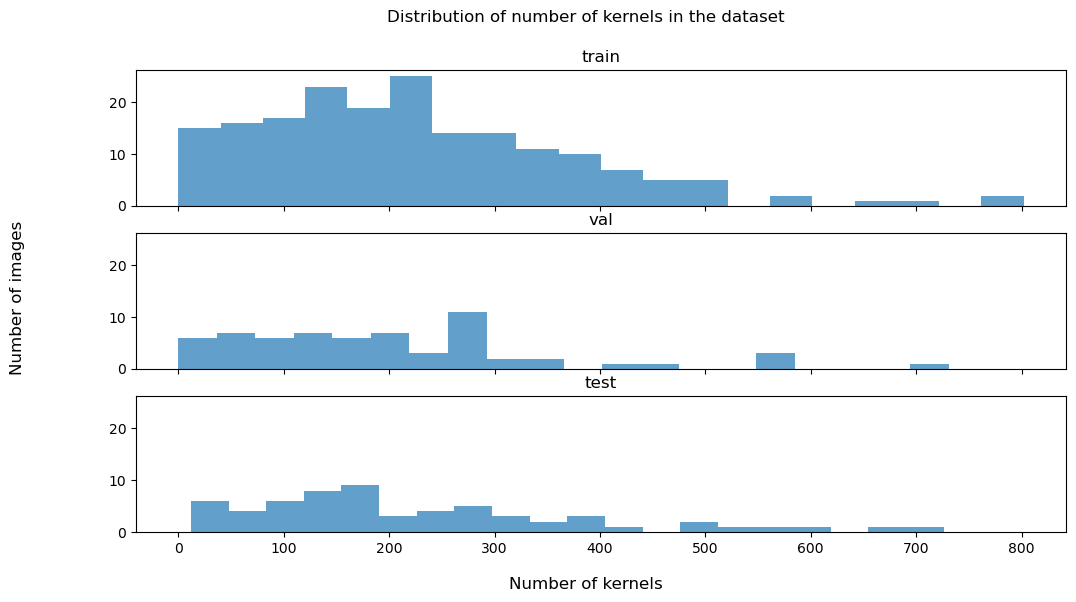

In [81]:
# Plot dataset distribution
fig, ax = plt.subplots(3,figsize=(12, 6), sharex=True, sharey=True)
fig.suptitle("Distribution of number of kernels in the dataset")
fig.supxlabel("Number of kernels")
fig.supylabel("Number of images")
for i, name in enumerate(["train", "val", "test"]):
    ax[i].hist(eval(f"{name}_dict.values()"), bins=20, alpha=0.7, label=name)
    ax[i].set_title(name) 
plt.show()

Compute the Mean Absolute Percent Error (MAPE), also known as Mean Absolute Percent Deviation (MAPD), on the total count (henceforth referred to as “Count MAPE”) for the entire image. Count MAPE is given by
$$ \text{Count MAPE} = \frac{1}{J} \sum_{j=1}^J \left( \frac{| \text{Actual}_j - \text{Predicted}_j |}{\text{Actual}_j} \right) $$ 
where $J$ is the number of images, and $\text{Actual}_j$ and $\text{Predicted}_j$ are the actual and predicted number of objects in the image $j$, respectively. 

In [28]:
# Compute Count MAPE for each model
def count_mape(true_dict, pred_dict):
    """
    Compute the Count Mean Absolute Percentage Error (MAPE) between the true and predicted counts.

    Args:
    - true_dict (dict): A dictionary containing the true number of instances for each image.
    - pred_dict (dict): A dictionary containing the predicted number of instances for each image.

    Returns:
    - mape (float): The Count MAPE between the true and predicted counts.
    """
    mape = 0
    for key in true_dict.keys():
        mape += abs(true_dict.get(key) - pred_dict.get(key,0)) / true_dict.get(key)
    return mape / len(true_dict)

In [82]:
print(
    f"Count MAPE\n"
    f"Adam: {count_mape(test_dict, predicted_dict_adam)}\n"
    f"AdamW: {count_mape(test_dict, predicted_dict_baseline)}\n"
    f"SGD: {count_mape(test_dict, predicted_dict_sgd)}\n"
)

Count MAPE
Adam: 0.23526658746355072
AdamW: 0.19314877143648423
SGD: 0.2170506044924925



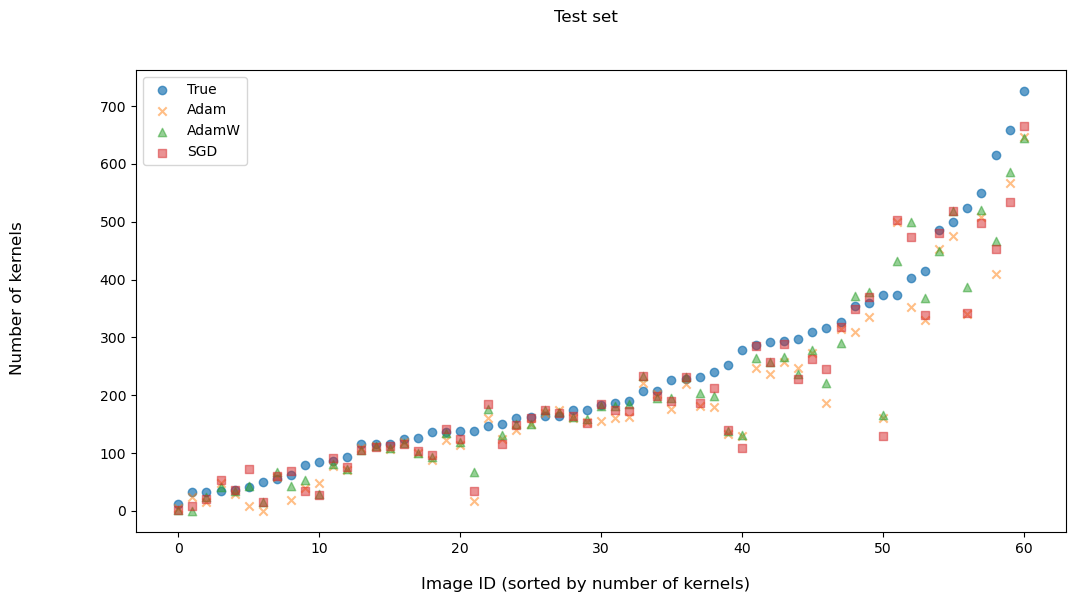

In [83]:
# Plot count for each image for each model 
# sort test dict by value
test_dict_sorted = dict(sorted(test_dict.items(), key=lambda x: x[1]))
fig, ax = plt.subplots(figsize=(12, 6))
fig.suptitle("Test set")
fig.supxlabel("Image ID (sorted by number of kernels)")
fig.supylabel("Number of kernels")
x_range = range(len(test_dict_sorted))
ax.scatter(x_range, test_dict_sorted.values(), label="True", alpha=0.7)
# Adam
ax.scatter(x_range, [predicted_dict_adam.get(k,0) for k in test_dict_sorted.keys()], label="Adam", alpha=0.5, marker="x")
# AdamW
ax.scatter(x_range, [predicted_dict_baseline.get(k,0) for k in test_dict_sorted.keys()], label="AdamW", alpha=0.5, marker="^")
# SGD
ax.scatter(x_range, [predicted_dict_sgd.get(k,0) for k in test_dict_sorted.keys()], label="SGD", alpha=0.5, marker="s")
ax.legend()

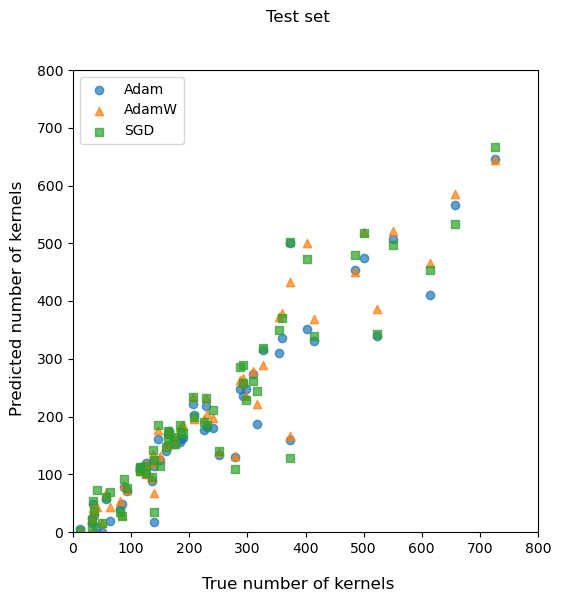

In [89]:
fig, ax = plt.subplots(figsize=(6, 6))
fig.suptitle("Test set")
fig.supxlabel("True number of kernels")
fig.supylabel("Predicted number of kernels")
gt_values = list(test_dict_sorted.values())
# Truncate axes to 800
ax.set_xlim(0, 800)
ax.set_ylim(0, 800)
# Adam
ax.scatter(gt_values, [predicted_dict_adam.get(k,0) for k in test_dict_sorted.keys()], label="Adam", alpha=0.7, marker="o")
# AdamW
ax.scatter(gt_values, [predicted_dict_baseline.get(k,0) for k in test_dict_sorted.keys()], label="AdamW", alpha=0.7, marker="^")
# SGD
ax.scatter(gt_values, [predicted_dict_sgd.get(k,0) for k in test_dict_sorted.keys()], label="SGD", alpha=0.7, marker="s")
plt.legend(loc="upper left")

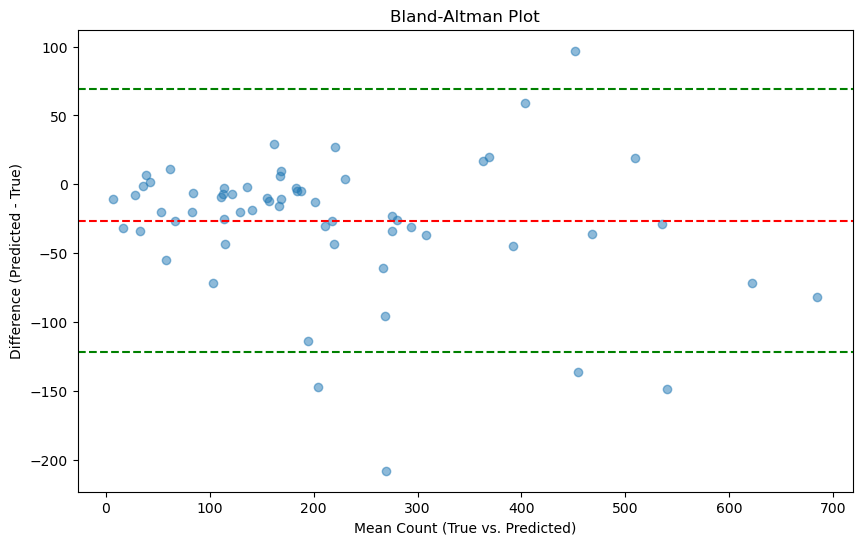

In [87]:
# Assuming gt_values are ground truth and pred_values are predictions from one of the models
pred_values = [predicted_dict_baseline.get(k, 0) for k in test_dict_sorted.keys()]  # Example for AdamW

# Calculate means and differences
means = np.mean([gt_values, pred_values], axis=0)
differences = np.subtract(pred_values, gt_values)

# Bland-Altman plot
plt.figure(figsize=(10, 6))
plt.scatter(means, differences, alpha=0.5)
plt.axhline(np.mean(differences), color='red', linestyle='--')  # Mean difference
plt.axhline(np.mean(differences) + 1.96*np.std(differences), color='green', linestyle='--')  # Upper limit of agreement
plt.axhline(np.mean(differences) - 1.96*np.std(differences), color='green', linestyle='--')  # Lower limit of agreement
plt.title('Bland-Altman Plot')
plt.xlabel('Mean Count (True vs. Predicted)')
plt.ylabel('Difference (Predicted - True)')
plt.show()